# Top overlapping AMR genes by weighted sum for ecoli cohort

In [1]:
import pandas as pd


pd.set_option("display.max_columns", None) # show all cols
pd.set_option('display.max_colwidth', None) # show full width of showing cols
pd.set_option("display.expand_frame_repr", False) # print cols side by side as it's supposed to be

## Read token information from bed files

In [ ]:
import os
import pandas as pd
from pathlib import Path


bedDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'bed_files', 'ECOLI')

bedDfList = []
for bedFile in os.listdir(bedDir):
    tubeid = bedFile.split('.')[0].split('_')[0]
    tokensDf = pd.read_csv(Path(bedDir, bedFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score'])
    tokensDf['tube_id'] = tubeid
    bedDfList.append(tokensDf)

bedDf = pd.concat(bedDfList, ignore_index=True)
bedDf

## Calculate token length

In [3]:
bedDf['token_length'] = bedDf.tokens.apply(lambda x: len(x))
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
0,1,1,3,GAA,0.024555,AH21B049,3
1,1,4,12,AAACCCCGG,0.019281,AH21B049,9
2,1,13,17,TCAAT,0.042749,AH21B049,5
3,1,18,22,AAGGC,0.058446,AH21B049,5
4,1,23,27,CGGGG,-0.002272,AH21B049,5
...,...,...,...,...,...,...,...
247349726,5,259913,259920,GCTACCCG,0.012245,ALF22C077,8
247349727,5,259921,259928,TTGGTGTG,0.000125,ALF22C077,8
247349728,5,259929,259938,CCTGTTCCGT,-0.000540,ALF22C077,10
247349729,5,259939,259942,GGCC,0.024973,ALF22C077,4


In [4]:
len(bedDf.tokens.unique())

31990

In [33]:
highscoreCutoff = bedDf.score.mean() + 3 * bedDf.score.std()
highscoreCutoff

np.float64(0.10044996853550375)

In [34]:
highscoreDf = bedDf[bedDf.score > highscoreCutoff]
highscoreDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
790,1,5456,5461,TTCCGG,0.109817,AH21B049,6
1113,1,7709,7713,CCGAC,0.111683,AH21B049,5
1141,1,7901,7906,GGTTTT,0.126671,AH21B049,6
1147,1,7939,7943,GACAG,0.138056,AH21B049,5
1544,1,10694,10701,CCCGACGG,0.119595,AH21B049,8
...,...,...,...,...,...,...,...
247348343,5,250450,250457,CCCTTTTT,0.104689,ALF22C077,8
247348387,5,250737,250741,ACAGA,0.114884,ALF22C077,5
247349058,5,255352,255357,GAAAAA,0.100641,ALF22C077,6
247349081,5,255503,255508,ACGCTG,0.112193,ALF22C077,6


In [35]:
highscoreDf.shape

(3266793, 7)

In [36]:
highscoreDf.token_length.value_counts()

token_length
6     1005832
7      585361
5      449264
8      339503
9      263575
4      262709
3      186469
10      92597
2       40984
11      30865
1        4650
12       2730
16       1991
15        152
13        102
14          9
Name: count, dtype: int64

<Axes: xlabel='token_length', ylabel='Count'>

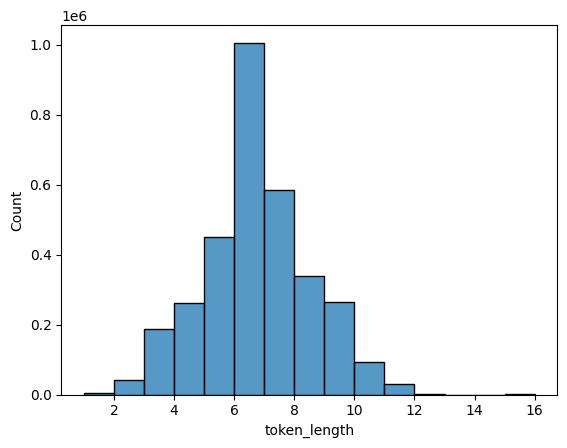

In [37]:
import seaborn as sns


sns.histplot(highscoreDf.token_length, binwidth=1)

## Read bed files containing overlapping tokens and attribution scores

In [38]:
from tqdm import tqdm


amrfinderDir = Path(os.environ['GENOMICS_DATA_BASE'], 'amrfinder')

overlappingDfList = []
for tubeId in tqdm(bedDf.tube_id.unique()):
    tubeidHighscoreDf = highscoreDf[highscoreDf.tube_id == tubeId]
    amrfinderFile = Path(amrfinderDir, tubeId + '_amr_results.txt')
    if(amrfinderFile.exists()):
        amrfinderDf = pd.read_csv(amrfinderFile, sep='\t')
        mergedDf = tubeidHighscoreDf.merge(
            amrfinderDf,
            how='inner',
            left_on = ['contig_id'],
            right_on = ['Contig id'],
        )
        mergedDf['tube_code'] = tubeId
        tubeidOverlappingDf = mergedDf[(mergedDf.start_position >= mergedDf.Start) & (mergedDf.end_position <= mergedDf.Stop)]
        overlappingDfList.append(tubeidOverlappingDf)

overlappingDf = pd.concat(overlappingDfList, ignore_index=True)
overlappingDf

100%|██████████| 861/861 [02:09<00:00,  6.65it/s]


,contig_id,start_position,end_position,tokens,score,tube_id,token_length,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description,tube_code
0,1,395434,395439,GAACGT,0.107013,AH21B049,6,NaN,1,394617,395984,+,ibeA,putative intracellular survival FAD-dependent oxidoreductase IbeA,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,456,456,100.0,97.81,456,AAF98391.2,putative intracellular survival FAD-dependent oxidoreductase IbeA,NaN,NaN,AH21B049
1,4,10223,10231,TTTCACATC,0.125651,AH21B049,9,NaN,4,5811,10370,-,sslE,lipoprotein metalloprotease SslE,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1520,1520,100.0,92.43,1520,ADE89421.1,lipoprotein metalloprotease SslE,NaN,NaN,AH21B049
2,4,10271,10276,GGAGGA,0.156269,AH21B049,6,NaN,4,5811,10370,-,sslE,lipoprotein metalloprotease SslE,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1520,1520,100.0,92.43,1520,ADE89421.1,lipoprotein metalloprotease SslE,NaN,NaN,AH21B049
3,4,10299,10304,CAACCG,0.104414,AH21B049,6,NaN,4,5811,10370,-,sslE,lipoprotein metalloprotease SslE,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1520,1520,100.0,92.43,1520,ADE89421.1,lipoprotein metalloprotease SslE,NaN,NaN,AH21B049
4,4,322635,322639,ACCGA,0.120406,AH21B049,5,NaN,4,322345,325446,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH21B049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14814,5,348217,348226,CTGGGCTGGG,0.121704,AH19C036,10,NaN,5,346159,349260,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH19C036
14815,5,348237,348242,CTGACC,0.110060,AH19C036,6,NaN,5,346159,349260,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH19C036
14816,5,348254,348260,CCAGTTG,0.100546,AH19C036,7,NaN,5,346159,349260,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH19C036
14817,5,348533,348535,CGC,0.107089,AH19C036,3,NaN,5,346159,349260,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH19C036


## Calculate weighted sum for all the genes overlapping with high-score tokens

In [39]:
import numpy as np


geneWeightedsumDf = overlappingDf.groupby(by=['Gene symbol']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})
geneWeightedsumDf

/tmp/ipykernel_7911/4136738264.py:4: FutureWarning: The provided callable <function sum at 0x729831f703a0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  geneWeightedsumDf = overlappingDf.groupby(by=['Gene symbol']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})


,Gene symbol,weighted_sum
0,aac(3)-IId,0.842917
1,aadA1,1.352251
2,acrF,355.481338
3,afaC,2.763001
4,arsC,6.679772
...,...,...
56,tir,0.385088
57,vactox,49.709257
58,ybtP,233.466095
59,ybtQ,190.821463


## Get overlapping genes for the tokens

In [41]:
tokenOverlapsDf = overlappingDf.merge(
    bedDf[['contig_id', 'start_position', 'end_position', 'tokens']],
    on=['contig_id', 'start_position', 'end_position', 'tokens'],
    how='inner',
)
tokenOverlapsDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description,tube_code
0,1,395434,395439,GAACGT,0.107013,AH21B049,6,NaN,1,394617,395984,+,ibeA,putative intracellular survival FAD-dependent oxidoreductase IbeA,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,456,456,100.0,97.81,456,AAF98391.2,putative intracellular survival FAD-dependent oxidoreductase IbeA,NaN,NaN,AH21B049
1,4,10223,10231,TTTCACATC,0.125651,AH21B049,9,NaN,4,5811,10370,-,sslE,lipoprotein metalloprotease SslE,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1520,1520,100.0,92.43,1520,ADE89421.1,lipoprotein metalloprotease SslE,NaN,NaN,AH21B049
2,4,10271,10276,GGAGGA,0.156269,AH21B049,6,NaN,4,5811,10370,-,sslE,lipoprotein metalloprotease SslE,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1520,1520,100.0,92.43,1520,ADE89421.1,lipoprotein metalloprotease SslE,NaN,NaN,AH21B049
3,4,10299,10304,CAACCG,0.104414,AH21B049,6,NaN,4,5811,10370,-,sslE,lipoprotein metalloprotease SslE,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1520,1520,100.0,92.43,1520,ADE89421.1,lipoprotein metalloprotease SslE,NaN,NaN,AH21B049
4,4,322635,322639,ACCGA,0.120406,AH21B049,5,NaN,4,322345,325446,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH21B049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31807,5,348217,348226,CTGGGCTGGG,0.121704,AH19C036,10,NaN,5,346159,349260,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH19C036
31808,5,348237,348242,CTGACC,0.110060,AH19C036,6,NaN,5,346159,349260,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH19C036
31809,5,348254,348260,CCAGTTG,0.100546,AH19C036,7,NaN,5,346159,349260,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH19C036
31810,5,348533,348535,CGC,0.107089,AH19C036,3,NaN,5,346159,349260,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH19C036


In [42]:
len(tokenOverlapsDf.tokens.unique()), len(tokenOverlapsDf['Gene symbol'].unique())

(1795, 61)

## Visualise weighted sum

<Axes: xlabel='weighted_sum', ylabel='Count'>

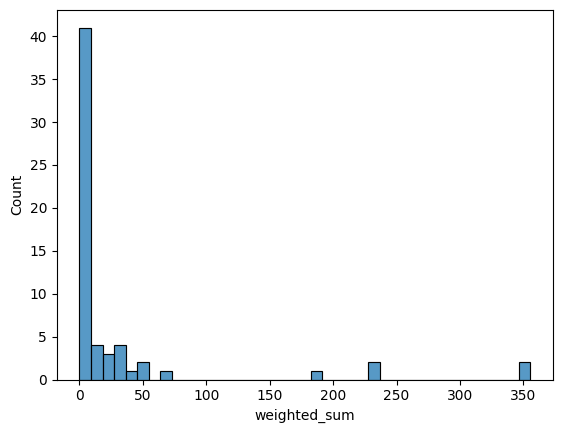

In [40]:
import seaborn as sns


sns.histplot(geneWeightedsumDf.weighted_sum)

## Top genes based on the weighted sum

In [43]:
geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20]

,Gene symbol,weighted_sum
2,acrF,355.481338
55,sslE,351.439720
58,ybtP,233.466095
26,fdeC,232.889307
59,ybtQ,190.821463
46,papC,64.358820
57,vactox,49.709257
9,blaEC,45.826660
7,asr,41.276852
23,espX1,35.806859


## Create gene-type lookup table from amrfinderplus annotations

In [44]:
import os

import pandas as pd

from pathlib import Path


amrfinderDir = Path(os.environ['GENOMICS_DATA_BASE'], 'amrfinder')

amrfinderDfList = []
for amrfinderFile in os.listdir(amrfinderDir):
    amrfinderDf = pd.read_csv(Path(amrfinderDir, amrfinderFile), sep='\t')
    amrfinderDfList.append(amrfinderDf)

allAmrfinderDf = pd.concat(amrfinderDfList, ignore_index=True)
allAmrfinderDf

/tmp/ipykernel_7911/536070399.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  allAmrfinderDf = pd.concat(amrfinderDfList, ignore_index=True)


,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description
0,NaN,1,83926,85452,-,aur,zinc metalloproteinase aureolysin,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,509,509,100.00,99.41,509,EHO93748.1,zinc metalloproteinase aureolysin,NaN,NaN
1,NaN,1,128415,129464,+,icaC,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,plus,VIRULENCE,VIRULENCE,NaN,NaN,EXACTX,350,350,100.00,100.00,350,AUU58561.1,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,NaN,NaN
2,NaN,1,150950,154498,-,cna,collagen adhesin Cna,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1183,1183,100.00,98.31,1183,BAB96477.1,collagen adhesin Cna,NaN,NaN
3,NaN,1,277464,278813,+,tet(38),tetracycline efflux MFS transporter Tet(38),core,AMR,AMR,TETRACYCLINE,TETRACYCLINE,EXACTX,450,450,100.00,100.00,450,WP_001100300.1,tetracycline efflux MFS transporter Tet(38),NaN,NaN
4,NaN,1,505300,506652,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.00,99.33,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57610,NaN,17,83399,84580,-,emrD,multidrug efflux MFS transporter EmrD,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,394,394,100.00,99.24,394,ACN65732.1,multidrug efflux MFS transporter EmrD,NaN,NaN
57611,NaN,2,213498,214724,-,kdeA,multidrug efflux MFS transporter KdeA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,409,410,99.76,99.02,409,ABR76310.1,multidrug efflux MFS transporter KdeA,NaN,NaN
57612,NaN,3,59710,60882,+,oqxA,multidrug efflux RND transporter periplasmic adaptor subunit OqxA,core,AMR,AMR,PHENICOL/QUINOLONE,PHENICOL/QUINOLONE,BLASTX,391,391,100.00,99.23,391,WP_002914189.1,multidrug efflux RND transporter periplasmic adaptor subunit OqxA,NaN,NaN
57613,NaN,3,60909,64058,+,oqxB9,multidrug efflux RND transporter permease subunit OqxB9,core,AMR,AMR,PHENICOL/QUINOLONE,PHENICOL/QUINOLONE,ALLELEX,1050,1050,100.00,100.00,1050,WP_012967412.1,multidrug efflux RND transporter permease subunit OqxB9,NaN,NaN


In [48]:
genetypeLookupDf = allAmrfinderDf[['Gene symbol', 'Element type']].drop_duplicates()
genetypeLookupDf

,Gene symbol,Element type
0,aur,VIRULENCE
1,icaC,VIRULENCE
2,cna,VIRULENCE
3,tet(38),AMR
4,mepA,AMR
...,...,...
55837,blaPDC-58,AMR
56358,blaACT-49,AMR
56951,blaNDM-4,AMR
56963,aac(6')-Ib-cr,AMR


## Add gene descriptions to the top genes

In [49]:
geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20].merge(
    genetypeLookupDf,
    on=['Gene symbol'],
    how='left'
)

,Gene symbol,weighted_sum,Element type
0,acrF,355.481338,AMR
1,sslE,351.439720,VIRULENCE
2,ybtP,233.466095,VIRULENCE
3,fdeC,232.889307,VIRULENCE
4,ybtQ,190.821463,VIRULENCE
5,papC,64.358820,VIRULENCE
6,vactox,49.709257,VIRULENCE
7,blaEC,45.826660,AMR
8,asr,41.276852,STRESS
9,espX1,35.806859,VIRULENCE


## Save all gene hits

In [82]:
import os
import pandas as pd
from pathlib import Path


outputFile = Path(os.environ['GENOMICS_DATA_BASE'], 'temp', 'ecoli_top_amrgenes_overlaping_3sd_tokens.csv')
geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False).merge(
    genetypeLookupDf,
    on=['Gene symbol'],
    how='left'
).drop_duplicates().to_csv(outputFile, index=False)

## Read mapping information

In [51]:
import os

import pandas as pd


demoTrainDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_train.csv', sep='\t')
demoTestDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_test.csv', sep='\t')
demoValidateDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_validate.csv', sep='\t')
demoDf = pd.concat([demoTrainDf, demoTestDf, demoValidateDf], ignore_index=True)
demoDf

,person_id,visit_occurrence_id,TYPE,COUNTRY_OF_BIRTH,SEX,Age_Bin,JOURNEY_ID
0,678487,3312694,Emergency,Australia,Male,"(60, 70]",3312694
1,2094045,9199249,Emergency,Australia,Male,"(20, 30]",9199249
2,2107813,9410987,Emergency,Australia,Male,"(50, 60]",9410987
3,2083212,602890,Inpatient,Australia,Female,"(40, 50]",9039437
4,2083212,9039437,Emergency,Australia,Female,"(40, 50]",9039437
...,...,...,...,...,...,...,...
7194,2603535,16588204,Inpatient,Australia,Male,"(60, 70]",16588204
7195,2603535,16709341,Inpatient,Australia,Male,"(60, 70]",16709341
7196,2603535,16651755,Inpatient,Australia,Male,"(60, 70]",16651755
7197,2098616,16872774,Emergency,Australia,Female,"(80, 90]",16872774


In [52]:
import os

mappingDf = pd.read_csv(os.environ['GENOMICS_DATA_BASE'] + '/patient_tube_id_mapping_full.tsv', sep='\t')
mappingDf

,tube_code,PATIENT_ID,db_ID,pt_age,pt_gender,EPISODE_ID,hospital_admission,hospital_discharge,hospital_in_last_year,genome_species,species_reported,contig_number,length,tube_code_duplicate_or_old,date_of_collection,ID_number,location_additional_02,collected_from_original
0,AH19J072,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Escherichia coli,Escherichia coli,92,5131021,NaN,2019-10-30,19-303-0997,A-7EA;HAEM,Blood
1,AH19J074,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Streptococcus sp. D19,Streptococcus mitis group,84,2022991,NaN,2019-10-30,19-303-1174,A-7EA;HAEM,Blood Peripheral
2,AH19B003,526238.0,567AE,85,Male,640261.0,2019-02-04,2019-02-07,no,Escherichia coli,Escherichia coli,93,4942915,NaN,2019-02-03,19-034-1596,A-4WB;GMC,Blood
3,AH20A024,788941.0,3YBDS,58,Female,13194824.0,2020-01-16,2020-01-19,no,Escherichia coli,Escherichia coli,110,5149157,NaN,2020-01-16,20-016-2112,S-ED;Emergency,Blood Venous
4,AH20L041,1023735.0,2VJ78,42,Male,14210147.0,2020-12-18,2021-01-05,yes,Staphylococcus aureus,Staphylococcus aureus,46,2735216,NaN,2020-12-16,20-351-2856,Emergency Dept;nan,Blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3112,ALF22L076,639020.0,3S6HL,84,Male,17219899.0,2022-12-15,2022-12-20,yes,Streptococcus vestibularis,Streptococcus salivarius group,107,1938627,NaN,2022-12-15,22-349-2150,Ward 4WB,Blood Peripheral
3113,ALF22L089,655404.0,6EWBM,67,Female,NaN,NaN,NaN,NaN,Proteus columbae,Proteus vulgaris,152,3972219,NaN,2022-12-17,22-351-1465,Comm/Amb Clinic,Blood
3114,ALF22L138,2572048.0,YM5PJ,61,Male,NaN,NaN,NaN,NaN,Enterobacter roggenkampii,Enterobacter cloacae complex,66,4876179,NaN,2022-12-27,22-361-0202,Ward 7 East,Hick White Lum
3115,ALF23A102,2054964.0,5DYAH,35,Female,17294287.0,2023-01-12,2023-02-01,yes,Streptococcus constellatus,Streptococcus anginosus group,54,1869828,NaN,2023-01-11,23-011-3305,ICU,Blood Venous


In [53]:
mappedJourneyTubeIdsDf = mappingDf[['tube_code', 'PATIENT_ID', 'EPISODE_ID']].drop_duplicates().merge(
    demoDf[['person_id', 'visit_occurrence_id', 'JOURNEY_ID']],
    how='inner',
    left_on=['PATIENT_ID', 'EPISODE_ID'],
    right_on=['person_id', 'visit_occurrence_id']
).drop(
    columns=['PATIENT_ID', 'EPISODE_ID', 'visit_occurrence_id']
)[['person_id', 'JOURNEY_ID', 'tube_code']].drop_duplicates()
mappedJourneyTubeIdsDf

,person_id,JOURNEY_ID,tube_code
0,50056,13224842,AH20B011
1,62567,12645629,AH19G065
2,138108,14737781,AH21E052
3,211314,13955099,AH20J009
4,211314,13955099,KPN2214
...,...,...,...
512,2084373,16158768,ALF22C004
513,1058066,16759482,ALF22H089
514,2552781,16966609,ALF22J054
515,2638484,16969999,ALF22K143


## Read mortality labels

In [54]:
import os

import pandas as pd

from pathlib import Path


mortalityTrainDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_1', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_train.csv'), sep='\t')
mortalityTestDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_1', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_test.csv'), sep='\t')
mortalityValidateDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_1', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_validate.csv'), sep='\t')
mortalityDf = pd.concat([mortalityTrainDf, mortalityTestDf, mortalityValidateDf], ignore_index=True).drop_duplicates()
mortalityDf

,person_id,JOURNEY_ID,visit_occurrence_id,death_30_day
0,678487,3312694,3312694,0
1,2094045,9199249,9199249,0
2,2107813,9410987,9410987,1
5,2083212,9039437,602890,0
6,2083212,9039437,9039437,0
...,...,...,...,...
30815,2603535,16588204,16588204,0
30820,2603535,16709341,16709341,0
30832,2603535,16651755,16651755,0
30838,2098616,16872774,16872774,0


## Create annotations data matrix

In [55]:
geneWeightedsumDf

,Gene symbol,weighted_sum
0,aac(3)-IId,0.842917
1,aadA1,1.352251
2,acrF,355.481338
3,afaC,2.763001
4,arsC,6.679772
...,...,...
56,tir,0.385088
57,vactox,49.709257
58,ybtP,233.466095
59,ybtQ,190.821463


In [56]:

signatureAnnotationsDf = tokenOverlapsDf[tokenOverlapsDf['Gene symbol'].isin(geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20]['Gene symbol'])]
signatureAnnotationsDf


,contig_id,start_position,end_position,tokens,score,tube_id,token_length,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description,tube_code
0,1,395434,395439,GAACGT,0.107013,AH21B049,6,NaN,1,394617,395984,+,ibeA,putative intracellular survival FAD-dependent oxidoreductase IbeA,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,456,456,100.0,97.81,456,AAF98391.2,putative intracellular survival FAD-dependent oxidoreductase IbeA,NaN,NaN,AH21B049
1,4,10223,10231,TTTCACATC,0.125651,AH21B049,9,NaN,4,5811,10370,-,sslE,lipoprotein metalloprotease SslE,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1520,1520,100.0,92.43,1520,ADE89421.1,lipoprotein metalloprotease SslE,NaN,NaN,AH21B049
2,4,10271,10276,GGAGGA,0.156269,AH21B049,6,NaN,4,5811,10370,-,sslE,lipoprotein metalloprotease SslE,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1520,1520,100.0,92.43,1520,ADE89421.1,lipoprotein metalloprotease SslE,NaN,NaN,AH21B049
3,4,10299,10304,CAACCG,0.104414,AH21B049,6,NaN,4,5811,10370,-,sslE,lipoprotein metalloprotease SslE,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1520,1520,100.0,92.43,1520,ADE89421.1,lipoprotein metalloprotease SslE,NaN,NaN,AH21B049
4,4,322635,322639,ACCGA,0.120406,AH21B049,5,NaN,4,322345,325446,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH21B049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31807,5,348217,348226,CTGGGCTGGG,0.121704,AH19C036,10,NaN,5,346159,349260,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH19C036
31808,5,348237,348242,CTGACC,0.110060,AH19C036,6,NaN,5,346159,349260,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH19C036
31809,5,348254,348260,CCAGTTG,0.100546,AH19C036,7,NaN,5,346159,349260,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH19C036
31810,5,348533,348535,CGC,0.107089,AH19C036,3,NaN,5,346159,349260,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH19C036


In [57]:
signatureDataDf = signatureAnnotationsDf[['tube_code', 'Gene symbol']].drop_duplicates()
# Get one hot encoding of columns B
one_hot = pd.get_dummies(signatureDataDf['Gene symbol'])
# Drop column B as it is now encoded
signatureDataDf = signatureDataDf.drop('Gene symbol',axis = 1)
# Join the encoded df
signatureDataDf = signatureDataDf.join(one_hot)
signatureDataDf = signatureDataDf.loc[:, (signatureDataDf != 0).any(axis=0)]
signatureDataDf = signatureDataDf*1
signatureDataDf

,tube_code,acrF,asr,blaEC,emrD,emrE,espX1,fdeC,ibeA,ireA,iroN,mdtM,papA,papC,papF,papG-II,pic,sslE,vactox,ybtP,ybtQ
0,AH21B049,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,AH21B049,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,AH21B049,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23,AH21B049,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
26,AH20B073,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31783,AH19C036,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
31785,AH19C036,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
31787,AH19C036,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31788,AH19C036,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### Create datamatrix

In [58]:
dataDf = mortalityDf.merge(
    mappedJourneyTubeIdsDf,
    on=['person_id', 'JOURNEY_ID'],
    how='inner'
).drop(
    columns=['visit_occurrence_id']
).drop_duplicates().merge(
    signatureDataDf,
    on=['tube_code'],
    how='inner'
).drop(
    columns=['tube_code']
)
dataDf = dataDf.loc[:, (dataDf != 0).any(axis=0)]
dataDf

,person_id,JOURNEY_ID,death_30_day,acrF,asr,blaEC,emrD,emrE,espX1,fdeC,ibeA,ireA,iroN,mdtM,papA,papC,papF,papG-II,pic,sslE,vactox,ybtP,ybtQ
0,2100650,603830,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2100650,603830,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2100650,603830,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2137240,620642,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2139360,9941051,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,662636,16647452,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
265,662636,16647452,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
266,662636,16647452,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
267,2607724,16680760,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Calculate correlation

In [59]:
dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False)

,death_30_day,acrF,asr,blaEC,emrD,emrE,espX1,fdeC,ibeA,ireA,iroN,mdtM,papA,papC,papF,papG-II,pic,sslE,vactox,ybtP,ybtQ
death_30_day,1.000000,-0.021431,-0.046214,0.058848,0.014997,0.004222,-0.028853,0.013739,0.002401,0.032355,-0.048854,-0.026452,0.153327,0.002401,-0.034481,-0.059946,0.108216,-0.019645,0.105667,-0.072947,0.020499
papA,0.153327,-0.045377,-0.019503,-0.017871,-0.017871,-0.018702,-0.017871,-0.026464,-0.010633,-0.013072,-0.007491,-0.013072,1.000000,-0.010633,-0.005287,-0.009191,-0.005287,-0.031802,-0.015152,-0.028909,-0.032920
pic,0.108216,-0.032026,-0.013765,-0.012613,-0.012613,-0.013199,-0.012613,-0.018678,-0.007505,-0.009226,-0.005287,-0.009226,-0.005287,-0.007505,-0.003731,-0.006487,1.000000,-0.022446,-0.010694,-0.020404,-0.023235
vactox,0.105667,-0.091790,-0.039453,-0.036150,-0.036150,-0.037831,-0.036150,-0.053533,-0.021510,-0.026444,-0.015152,-0.026444,-0.015152,-0.021510,-0.010694,-0.018593,-0.010694,-0.064332,1.000000,-0.058479,-0.066593
blaEC,0.058848,-0.108258,-0.046531,1.000000,-0.042636,-0.044618,-0.042636,-0.063137,-0.025368,-0.031188,-0.017871,-0.031188,-0.017871,-0.025368,-0.012613,-0.021928,-0.012613,-0.075873,-0.036150,-0.068970,-0.078540
ireA,0.032355,-0.079190,-0.034037,-0.031188,-0.031188,-0.032638,-0.031188,-0.046184,-0.018557,1.000000,-0.013072,-0.022814,-0.013072,-0.018557,-0.009226,-0.016040,-0.009226,-0.055501,-0.026444,-0.050451,-0.057452
ybtQ,0.020499,-0.199424,-0.085715,-0.078540,-0.078540,-0.082192,-0.078540,-0.116306,-0.046732,-0.057452,-0.032920,-0.057452,-0.032920,-0.046732,-0.023235,-0.040395,-0.023235,-0.139768,-0.066593,-0.127051,1.000000
emrD,0.014997,-0.108258,-0.046531,-0.042636,1.000000,-0.044618,-0.042636,-0.063137,-0.025368,-0.031188,-0.017871,-0.031188,-0.017871,-0.025368,-0.012613,-0.021928,-0.012613,-0.075873,-0.036150,-0.068970,-0.078540
fdeC,0.013739,-0.160313,-0.068905,-0.063137,-0.063137,-0.066072,-0.063137,1.000000,-0.037567,-0.046184,-0.026464,-0.046184,-0.026464,-0.037567,-0.018678,-0.032473,-0.018678,-0.112356,-0.053533,-0.102134,-0.116306
emrE,0.004222,-0.113291,-0.048694,-0.044618,-0.044618,1.000000,-0.044618,-0.066072,-0.026548,-0.032638,-0.018702,-0.032638,-0.018702,-0.026548,-0.013199,-0.022948,-0.013199,-0.079401,-0.037831,-0.072177,-0.082192


### Plot correlations as a heatmap

<Axes: >

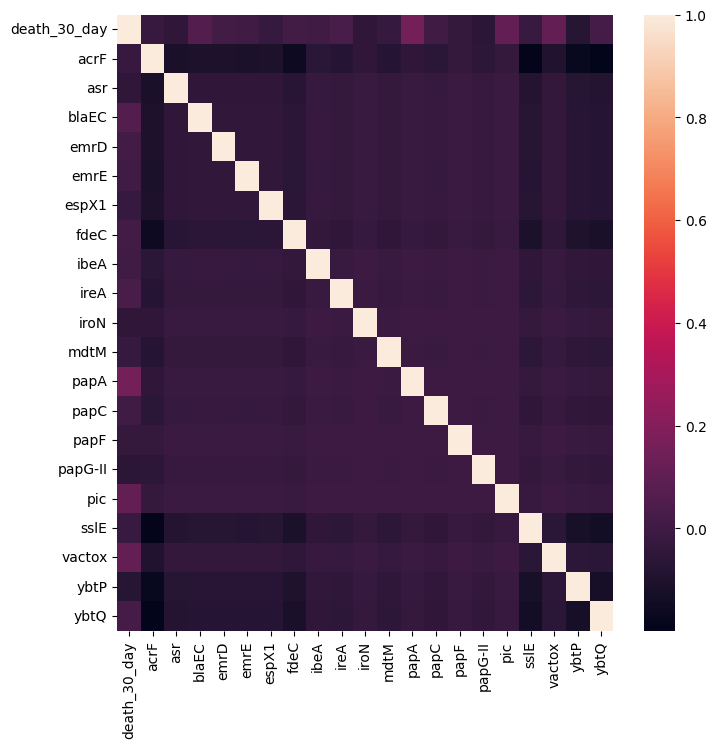

In [60]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr())

### Plot correlations as a heatmap (Log scale)

<Axes: >

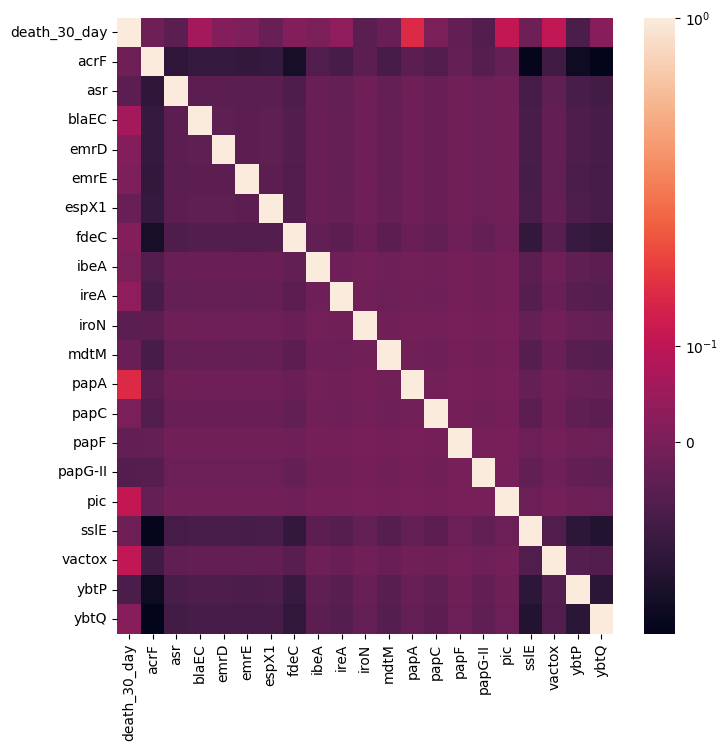

In [61]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr(), norm=SymLogNorm(linthresh=0.3))

### Model using machine learning

In [62]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_30_day'])
y = dataDf.death_30_day

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

accuracy_score(y_test, y_pred)

0.37037037037037035

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

accuracy_score(y_test, y_pred)

0.7777777777777778

In [65]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
18,ybtP,-0.717092
1,asr,-0.624813
9,iroN,-0.395587
10,mdtM,-0.286641
13,papF,-0.224756
14,papG-II,-0.224756
0,acrF,-0.204348
16,sslE,-0.149856
5,espX1,-0.147879
19,ybtQ,-0.115587


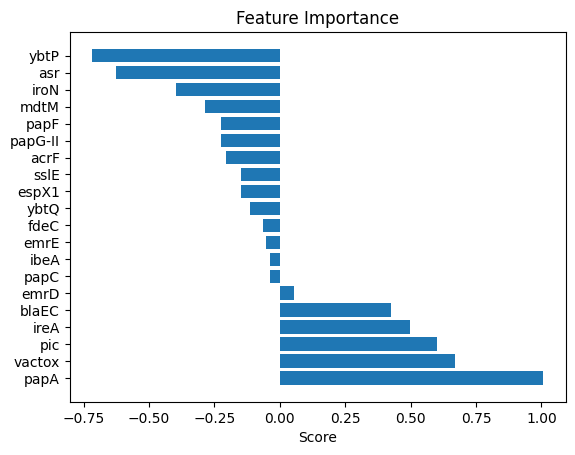

In [66]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()


## Create tokens data matrix

In [67]:
import numpy as np


tokenWeightedsumDf = overlappingDf.groupby(by=['tokens']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})
tokenWeightedsumDf

/tmp/ipykernel_7911/2946855819.py:4: FutureWarning: The provided callable <function sum at 0x729831f703a0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tokenWeightedsumDf = overlappingDf.groupby(by=['tokens']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})


,tokens,weighted_sum
0,A,0.543090
1,AAAAA,4.037453
2,AAAAAATTA,0.141076
3,AAAAAGAACC,1.519990
4,AAAAATAAT,0.769195
...,...,...
1790,TTTTGCCTGC,0.823813
1791,TTTTTAAA,0.134330
1792,TTTTTATC,0.103146
1793,TTTTTCAT,0.811376


In [68]:
signatureTokensDf = overlappingDf[overlappingDf['tokens'].isin(tokenWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20]['tokens'])]
signatureTokensDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description,tube_code
4,4,322635,322639,ACCGA,0.120406,AH21B049,5,NaN,4,322345,325446,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH21B049
10,4,322941,322946,CCGGTT,0.235926,AH21B049,6,NaN,4,322345,325446,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH21B049
13,4,323040,323044,TCGAT,0.203242,AH21B049,5,NaN,4,322345,325446,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH21B049
19,4,323794,323801,TTGCGCTG,0.105214,AH21B049,8,NaN,4,322345,325446,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH21B049
21,4,324719,324721,CGC,0.110858,AH21B049,3,NaN,4,322345,325446,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH21B049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14797,5,33239,33242,CTGT,0.118868,AH19C036,4,NaN,5,31275,35834,-,sslE,lipoprotein metalloprotease SslE,plus,VIRULENCE,VIRULENCE,NaN,NaN,EXACTX,1520,1520,100.0,100.00,1520,ADE89421.1,lipoprotein metalloprotease SslE,NaN,NaN,AH19C036
14799,5,35085,35090,GGTTTT,0.144816,AH19C036,6,NaN,5,31275,35834,-,sslE,lipoprotein metalloprotease SslE,plus,VIRULENCE,VIRULENCE,NaN,NaN,EXACTX,1520,1520,100.0,100.00,1520,ADE89421.1,lipoprotein metalloprotease SslE,NaN,NaN,AH19C036
14801,5,35327,35332,GGTTTT,0.217303,AH19C036,6,NaN,5,31275,35834,-,sslE,lipoprotein metalloprotease SslE,plus,VIRULENCE,VIRULENCE,NaN,NaN,EXACTX,1520,1520,100.0,100.00,1520,ADE89421.1,lipoprotein metalloprotease SslE,NaN,NaN,AH19C036
14807,5,347608,347615,TTGCGCTG,0.105573,AH19C036,8,NaN,5,346159,349260,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH19C036


In [69]:
signatureDataDf = signatureTokensDf[['tube_code', 'tokens']].drop_duplicates()
# Get one hot encoding of columns B
one_hot = pd.get_dummies(signatureDataDf['tokens'])
# Drop column B as it is now encoded
signatureDataDf = signatureDataDf.drop('tokens',axis = 1)
# Join the encoded df
signatureDataDf = signatureDataDf.join(one_hot)
signatureDataDf = signatureDataDf.loc[:, (signatureDataDf != 0).any(axis=0)]
signatureDataDf = signatureDataDf*1
signatureDataDf


,tube_code,AAGGC,ACCGA,ACGCT,ACGCTG,AT,ATTT,CACCCA,CCGGTT,CGC,CGCC,CGCCGCC,CTGA,CTGT,CTGTTC,GCTAAC,GGTTTT,TATCAGGA,TCGAT,TGAT,TTGCGCTG
4,AH21B049,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,AH21B049,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
13,AH21B049,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
19,AH21B049,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
21,AH21B049,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14792,AH19C036,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14797,AH19C036,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
14799,AH19C036,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
14807,AH19C036,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Create datamatrix

In [70]:
dataDf = mortalityDf.merge(
    mappedJourneyTubeIdsDf,
    on=['person_id', 'JOURNEY_ID'],
    how='inner'
).drop(
    columns=['visit_occurrence_id']
).drop_duplicates().merge(
    signatureDataDf,
    on=['tube_code'],
    how='inner'
).drop(
    columns=['tube_code']
)
dataDf = dataDf.loc[:, (dataDf != 0).any(axis=0)]
dataDf

,person_id,JOURNEY_ID,death_30_day,AAGGC,ACCGA,ACGCT,ACGCTG,AT,ATTT,CACCCA,CCGGTT,CGC,CGCC,CGCCGCC,CTGA,CTGT,CTGTTC,GCTAAC,GGTTTT,TATCAGGA,TCGAT,TGAT,TTGCGCTG
0,2100650,603830,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2100650,603830,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2100650,603830,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,2100650,603830,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2100650,603830,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,2607724,16680760,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
314,2607724,16680760,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
315,2607724,16680760,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
316,2607724,16680760,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


### Calculate correlation

In [71]:
dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False)

,death_30_day,AAGGC,ACCGA,ACGCT,ACGCTG,AT,ATTT,CACCCA,CCGGTT,CGC,CGCC,CGCCGCC,CTGA,CTGT,CTGTTC,GCTAAC,GGTTTT,TATCAGGA,TCGAT,TGAT,TTGCGCTG
death_30_day,1.000000,-0.059033,-0.059033,0.090764,-0.001843,-0.003025,0.075477,0.107096,-0.079706,0.001808,-0.052845,0.094428,-0.036882,-0.090670,-0.046608,-0.025206,0.004703,0.081205,0.000864,-0.071355,-0.018125
CACCCA,0.107096,-0.035831,-0.035831,-0.056484,-0.052854,-0.040621,-0.028399,1.000000,-0.028399,-0.067632,-0.043570,-0.051605,-0.030408,-0.032305,-0.042116,-0.051605,-0.051605,-0.049038,-0.032305,-0.039079,-0.043570
CGCCGCC,0.094428,-0.051605,-0.051605,-0.081351,-0.076123,-0.058505,-0.040901,-0.051605,-0.040901,-0.097407,-0.062751,1.000000,-0.043796,-0.046527,-0.060658,-0.074324,-0.074324,-0.070627,-0.046527,-0.056284,-0.062751
ACGCT,0.090764,-0.056484,-0.056484,1.000000,-0.083320,-0.064036,-0.044768,-0.056484,-0.044768,-0.106616,-0.068683,-0.081351,-0.047936,-0.050926,-0.066393,-0.081351,-0.081351,-0.077304,-0.050926,-0.061605,-0.068683
TATCAGGA,0.081205,-0.049038,-0.049038,-0.077304,-0.072337,-0.055595,-0.038867,-0.049038,-0.038867,-0.092562,-0.059630,-0.070627,-0.041617,-0.044213,-0.057641,-0.070627,-0.070627,1.000000,-0.044213,-0.053485,-0.059630
ATTT,0.075477,-0.028399,-0.028399,-0.044768,-0.041891,-0.032196,1.000000,-0.028399,-0.022508,-0.053604,-0.034532,-0.040901,-0.024101,-0.025604,-0.033381,-0.040901,-0.040901,-0.038867,-0.025604,-0.030974,-0.034532
GGTTTT,0.004703,-0.051605,-0.051605,-0.081351,-0.076123,-0.058505,-0.040901,-0.051605,-0.040901,-0.097407,-0.062751,-0.074324,-0.043796,-0.046527,-0.060658,-0.074324,1.000000,-0.070627,-0.046527,-0.056284,-0.062751
CGC,0.001808,-0.067632,-0.067632,-0.106616,-0.099765,-0.076675,-0.053604,-0.067632,-0.053604,1.000000,-0.082240,-0.097407,-0.057397,-0.060977,-0.079497,-0.097407,-0.097407,-0.092562,-0.060977,-0.073765,-0.082240
TCGAT,0.000864,-0.032305,-0.032305,-0.050926,-0.047654,-0.036624,-0.025604,-0.032305,-0.025604,-0.060977,-0.039282,-0.046527,-0.027416,-0.029126,-0.037972,-0.046527,-0.046527,-0.044213,1.000000,-0.035234,-0.039282
ACGCTG,-0.001843,-0.052854,-0.052854,-0.083320,1.000000,-0.059921,-0.041891,-0.052854,-0.041891,-0.099765,-0.064270,-0.076123,-0.044856,-0.047654,-0.062127,-0.076123,-0.076123,-0.072337,-0.047654,-0.057647,-0.064270


### Plot correlations as a heatmap

<Axes: >

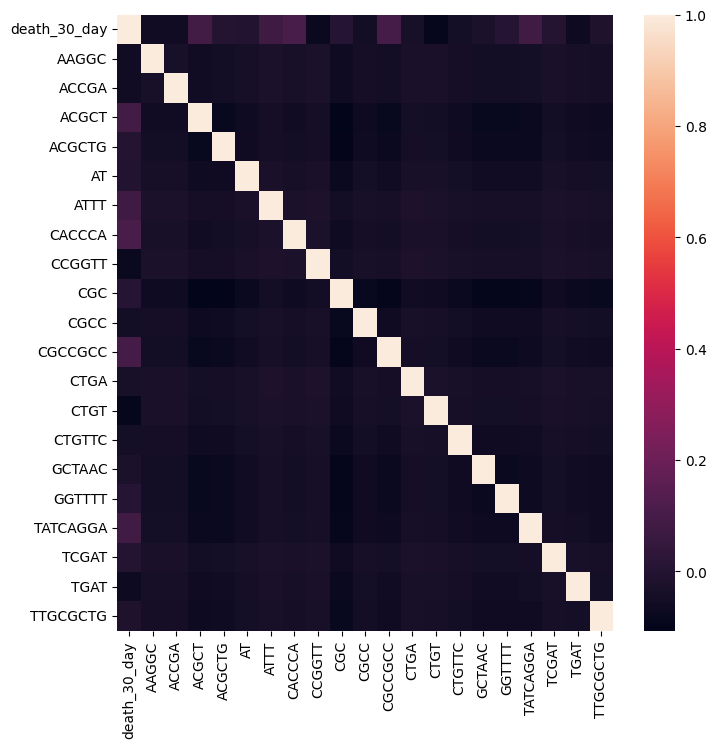

In [72]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr())

### Plot correlations as a heatmap (Log scale)

<Axes: >

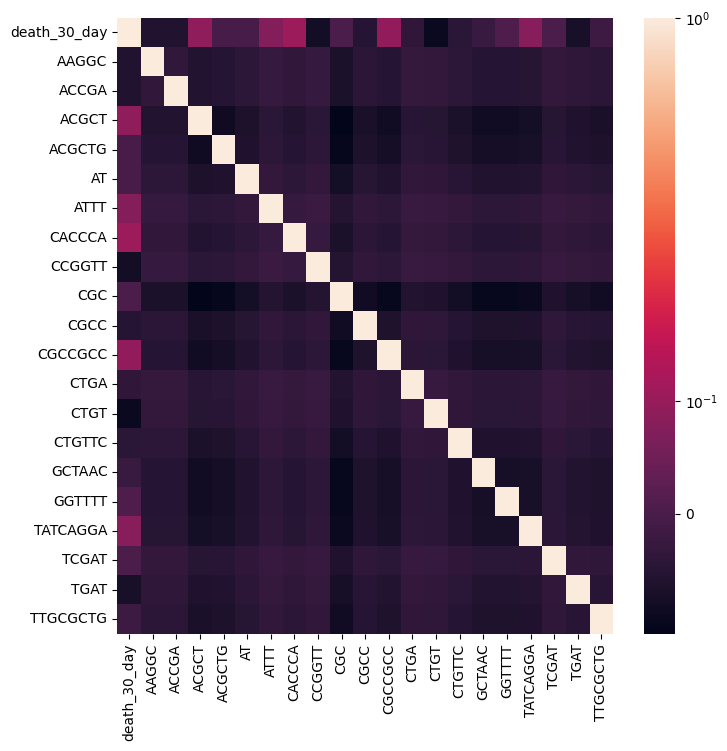

In [73]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr(), norm=SymLogNorm(linthresh=0.3))

### Model using machine learning

In [74]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_30_day'])
y = dataDf.death_30_day

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

accuracy_score(y_test, y_pred)

0.3125

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

accuracy_score(y_test, y_pred)

0.78125

In [77]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
14,GCTAAC,-0.818736
12,CTGT,-0.790419
1,ACCGA,-0.731075
7,CCGGTT,-0.593029
11,CTGA,-0.593029
9,CGCC,-0.454575
0,AAGGC,-0.393960
18,TGAT,-0.255742
13,CTGTTC,-0.236408
8,CGC,-0.047599


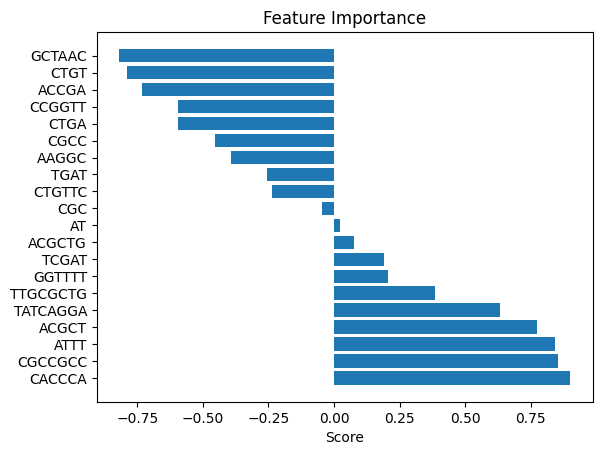

In [78]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()

### Get genes corresponding to the top tokens

#### Token `GAAGAAG` (+ve feature importance)

In [80]:
overlappingDf[overlappingDf.tokens == 'CACCCA'][['Gene symbol']].value_counts()[:20]

Gene symbol
ybtQ           63
ybtP           52
vactox         10
mchF            1
afaC            1
aac(3)-IId      1
mdtM            1
Name: count, dtype: int64

`ybtP` and `ybtQ`, that are probably involved in Ybt-mediated iron transport through the inner membrane

#### Token `GAAGAAG` (-ve feature importance)

In [81]:
overlappingDf[overlappingDf.tokens == 'GCTAAC'][['Gene symbol']].value_counts()[:20]

Gene symbol
acrF           69
ybtP           50
sslE           32
lpfA            4
ibeA            4
mdtM            2
fdeC            2
hlyA-alpha      1
papA            1
Name: count, dtype: int64

`AcrF`: inner membrane transporter